# Image Classification Using Local Binary Paterns(LBP)


## Loading the dataset

In [10]:
import numpy as np #import numpy for mathematiical operations and image representation
import tensorflow as tf #import tensorflow library for image operations and classification
from tensorflow import keras #import keras to build neural network
import os #imort os to access directories from the operating system
import cv2 

In [79]:

def dataLoader(Dataset_path):
    images = []
    labels = []
    label_map ={}

    if not os.path.exists(Dataset_path):
        raise FileNotFoundError (f"The file path {Dataset_path} does not exist.")
   #for every folder in my 'data' directory, loop thriugh abd return the iage as tensor and record the class labels
    for label, folder in enumerate(sorted(os.listdir(Dataset_path))):
        folder_path = os.path.join(Dataset_path, folder)
        label_map[label] = folder

        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            
            # Read the image as grayscale
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            # Resize the image to 64x64
            image = cv2.resize(image, (64, 64))
            # Append image and its corresponding label
            images.append(image)
            labels.append(label)

    # Convert images list to a NumPy array
    images = np.array(images)
    labels = np.array(labels)

    return images, labels, label_map

In [80]:
images, labels, label_map = dataLoader('data')

In [81]:
label_map[0] = "Exclamation (!)"
label_map[1] = "Left Parantheses"
label_map[2] = "Right Parenthese"
label_map[3] = "Zero"
label_map[4] = "Seven"
label_map[5] = "Nine"
label_map[6]= "Not Equal"

## Data Visualisation

In [82]:
import matplotlib.pyplot as plt



def visualise_few_images_per_class(img_array, labels, label_map, num_images_visualised_per_class=1,):
    #Set the size of the visualisation
    plt.figure(figsize=(10,10))
    labels = np.atleast_1d(labels)
    #get random indexes for the images in the image array based on their class value
    for classLabel, class_name in label_map.items():
        class_indices = np.where(labels == classLabel)[0]
        selected_indices = np.random.choice(class_indices,num_images_visualised_per_class,replace=False)

        for i, idx in enumerate(selected_indices):
            plt.subplot(len(label_map), num_images_visualised_per_class, classLabel * num_images_visualised_per_class + i + 1)
            plt.imshow(img_array[idx], cmap='gray')
            plt.title(class_name)
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

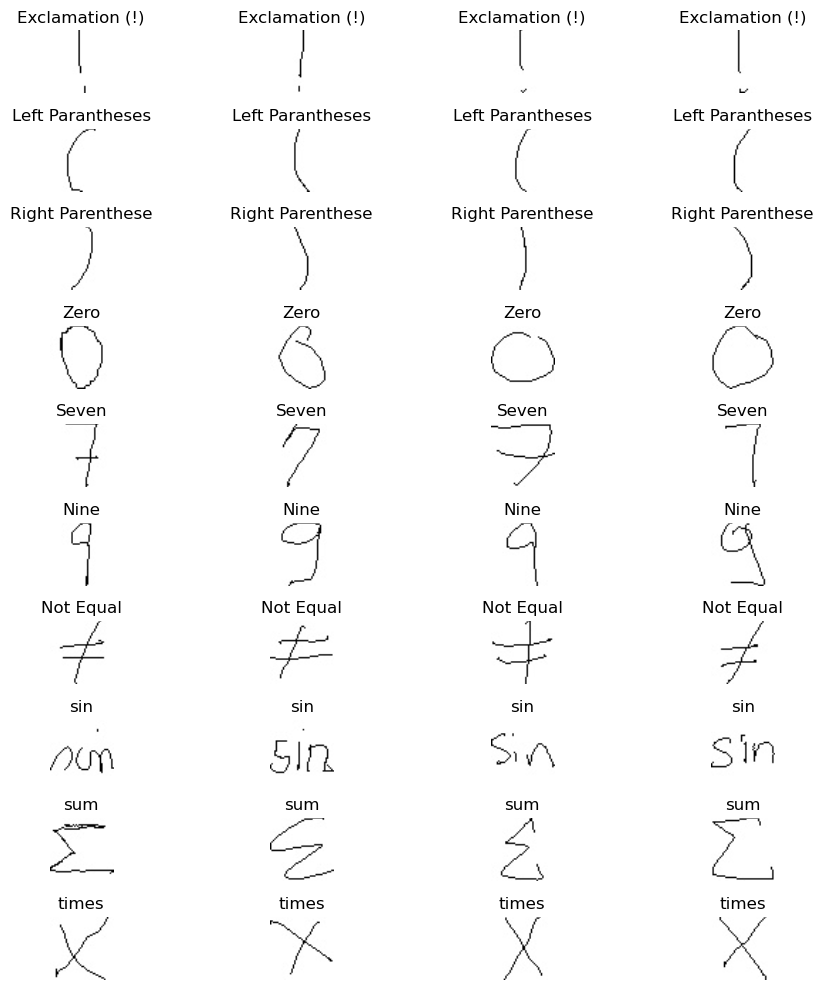

In [83]:
visualise_few_images_per_class(images, labels, label_map=label_map, num_images_visualised_per_class=4)

## Data Partitioning

In [84]:
from sklearn.model_selection import train_test_split
import numpy as np

X = np.array(images)
y= np.array(labels)
train_size=0.8
random_seed =42

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=random_seed, train_size=train_size)

In [85]:
print("The shape of the training set is ", X_train.shape)
print("The shape of the testing set is  ", X_test.shape)


The shape of the training set is  (4000, 64, 64)
The shape of the testing set is   (1000, 64, 64)


## Feature Extraction Using Local Binary Patterns(LBP)

In [125]:
import numpy as np
from skimage import feature

class LocalBinaryPatterns:
    def __init__(self, numPoints, radius):
        # Store the number of points and radius
        self.numPoints = numPoints
        self.radius = radius

    def LBPfeatures(self, images, eps=1e-7):
        lbp_features = []
        lbp_images = []  # Store LBP images for visualization

        for image in images:
            # Compute LBP representation of the image using 'uniform' method
            lbp = feature.local_binary_pattern(image, self.numPoints, self.radius, method="uniform")

            # Compute histogram
            hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, self.numPoints + 3), range=(0, self.numPoints + 2))

            # Normalize the histogram
            hist = hist.astype("float")
            hist /= (hist.sum() + eps)  # Avoid division by zero by adding epsilon

            # Store features and LBP images
            lbp_features.append(hist)
            lbp_images.append(lbp)  # Keep the full LBP image for visualization

        return np.array(lbp_features), lbp_images




**Function to visualise the lbp image**

In [123]:
def visualize_lbp(original_image, lbp_image):
    plt.figure(figsize=(10, 5))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # LBP-transformed image
    plt.subplot(1, 2, 2)
    plt.imshow(lbp_image, cmap='gray')
    plt.title('LBP Image')
    plt.axis('off')

    plt.show()


**Extract The features**

In [318]:
lbp_extractor = LocalBinaryPatterns(numPoints=10, radius=8)
X_train_features_extracted, X_train_lbp_images = lbp_extractor.LBPfeatures(X_train)
X_test_features_extracted, X_test_lbp_images = lbp_extractor.LBPfeatures(X_test)

**Visualise the LBP image**

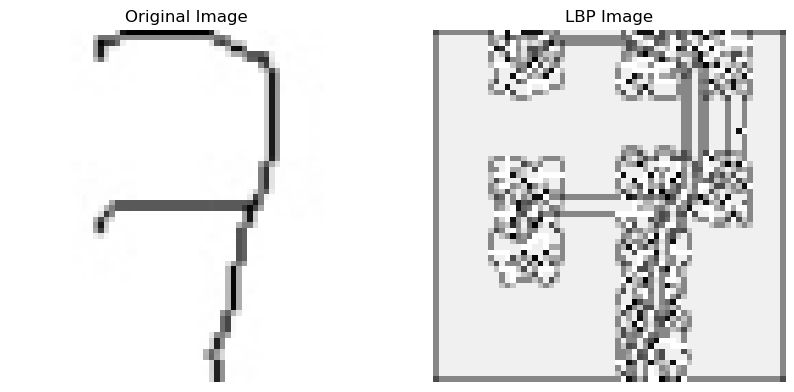

In [282]:
visualize_lbp(X_train[15], X_train_lbp_images[15])


## Support Vector Machine(SVM)

In [ ]:
from sklearn.svm import SVC

#only way i got high accyracy was to bump up my C value to 10000
svm_model = SVC(kernel='rbf', C=10000)
svm_model.fit(X_train_features_extracted, y_train)


SVC(C=10000)

**TRAINING ACCURACY**

In [331]:
# Training accuracy (on the data the model was trained on)
train_accuracy = svm_model.score(X_train_features_extracted, y_train)

print(f"Training Accuracy: {train_accuracy:.4f}")


Training Accuracy: 0.9200


### Testing And Model Evaulation

In [332]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
svm_y_pred = svm_model.predict(X_test_features_extracted)

Helper functions to visualise the evaluations

In [227]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def visualize_report(report):
    # Extracting metrics for each class
    metrics = ['precision', 'recall', 'f1-score', 'support']
    data = {metric: [] for metric in metrics}
    labels = []

    # Include class-specific metrics
    for cls, metrics_values in report.items():
        if cls.isdigit():
            labels.append(cls)
            for metric in metrics:
                data[metric].append(metrics_values.get(metric, None))

    # Convert data to DataFrame for easy plotting
    df = pd.DataFrame(data, index=labels)

    # Creating subplots for each metric
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    for ax, metric in zip(axes, metrics[:-1]): 
        sns.barplot(ax=ax, x=df.index, y=metric, data=df, hue=df.index)
        ax.set_title(f'{metric.capitalize()} by Class')
        ax.set_ylim(0, 1.1)
        ax.set_xlabel('Class')
        
    plt.tight_layout()
    plt.show()


In [200]:
import matplotlib.pyplot as plt 

def plot_confusionMatrix(confusion_matrix, label_map):
    class_names = [label_map[i] for i in range(len(label_map))]

    matrix_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=class_names)
    matrix_display.plot(cmap='Blues')
    plt.title('Confusion Matrix for SVM (Raw Pixel)')
    plt.xticks(rotation=90)
    plt.show()

**Print out the acuracy And Classification Report**

In [333]:
print("ACCURACY SCORE IS: ", accuracy_score(svm_y_pred, y_test))
print("CLASSIFICATION REPORT: \n", classification_report(svm_y_pred, y_test))

ACCURACY SCORE IS:  0.822
CLASSIFICATION REPORT: 
               precision    recall  f1-score   support

           0       0.81      0.91      0.86        99
           1       0.90      0.88      0.89       107
           2       0.91      0.83      0.87       115
           3       0.75      0.80      0.78        80
           4       0.73      0.80      0.77        86
           5       0.67      0.71      0.69        93
           6       0.98      0.87      0.92       110
           7       0.92      0.94      0.93       109
           8       0.70      0.66      0.68        86
           9       0.78      0.76      0.77       115

    accuracy                           0.82      1000
   macro avg       0.82      0.82      0.82      1000
weighted avg       0.83      0.82      0.82      1000



**Classification Reort And Confusion Matrix Visualised** 

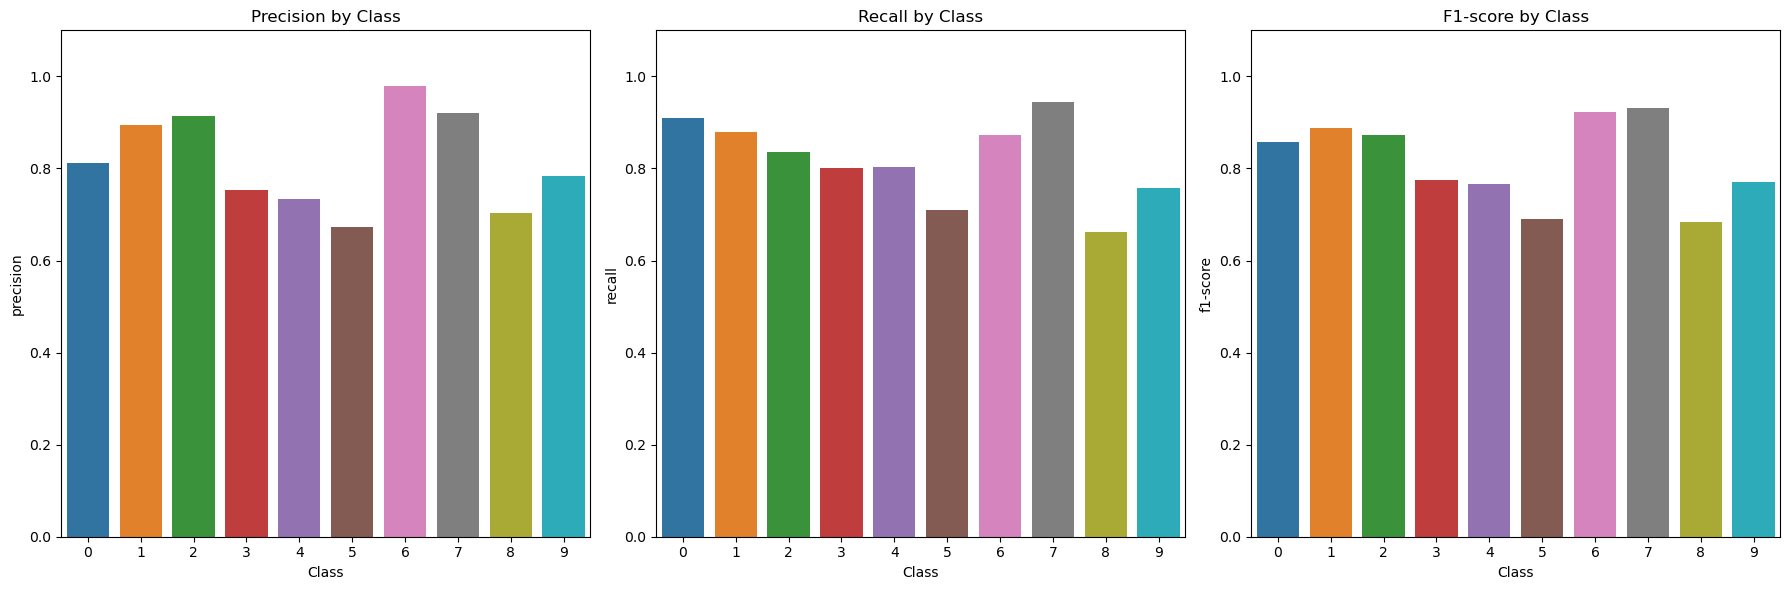

In [334]:
visualize_report(classification_report(svm_y_pred, y_test, output_dict=True))

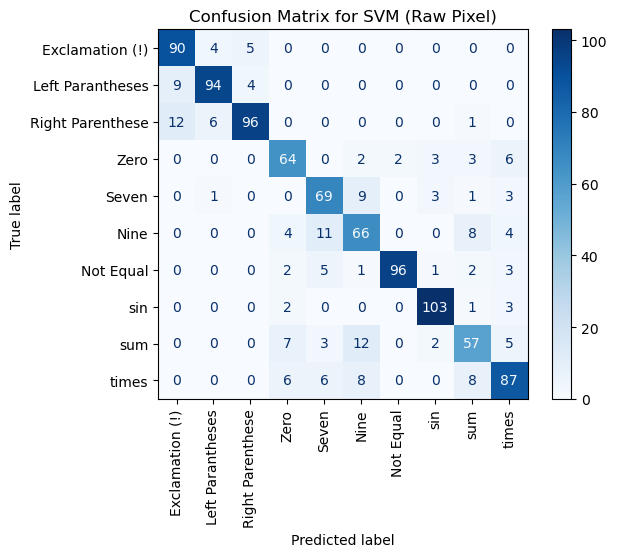

In [335]:
cm = confusion_matrix(svm_y_pred, y_test)
plot_confusionMatrix(cm, label_map=label_map)

### Visualising Misclassification

**Helper Function To visualise missclassification**

In [251]:
def visualise_misclassified_photos(images, y_pred, y_test,X_test, label_map,num_rows,num_cols):
    misclassified_indices = np.where(y_test!=y_pred)[0]
    predicted_labels = [label_map[y_pred[i]] for i in misclassified_indices]
    True_labels = [label_map[y_test[i]] for i in misclassified_indices]
    True_Photos = [X_test[i] for i in misclassified_indices]

    comparision = zip(predicted_labels, True_labels, True_Photos)


    fig,axs = plt.subplots(num_rows,num_cols, figsize=(100,100))
    axs = axs.flatten() # flatten into a 1D array

    for idx, (predicted_label, true_label, True_Photo) in enumerate(comparision):
        #we want tp plot each photo with the title of each hoto being predicted label,true label
        axs[idx].imshow(True_Photo, cmap='gray')
        axs[idx].set_title(f"Pred: {predicted_label}\nTrue: {true_label}", fontsize=10)

        axs[idx].axis('off')

    plt.tight_layout()
    plt.show()

In [337]:
misclassified_indices = np.where(y_test!=svm_y_pred)[0]
print("The number of misclassified photos is ", misclassified_indices.shape)

The number of misclassified photos is  (178,)


In [336]:
visualise_misclassified_photos(images, svm_y_pred,y_test,X_test,label_map,14,14)

## Artificial Neural Network(ANN)

Here we define an artificial Neural Network that will be used to classify the images by passing in the Local Binary Patterns outputs

In [156]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.optimizers import Adam

In [343]:
X_train_features_extracted.shape

(4000, 12)

In [409]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam

ANN_model = Sequential([ 
    Dense(128, input_shape=(12,)),
    Activation('relu'),

    Dense(128),
    Activation('relu'),

    Dense(64),
    Activation('relu'),

    Dense(10, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
ANN_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

ANN_model.summary()


c:\Users\61422\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_57 (Dense)                │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_34 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_35 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_36 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,082 (105.79 KB)

 Trainable params: 27,082 (105.79 KB)

 Non-trainable params: 0 (0.00 B)

In [423]:
ANN_model.fit(X_train_features_extracted, y_train, epochs=50, batch_size=10, validation_split=0.2)

Epoch 1/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8941 - loss: 0.3168 - val_accuracy: 0.7950 - val_loss: 0.7198
Epoch 2/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8869 - loss: 0.3350 - val_accuracy: 0.7900 - val_loss: 0.7064
Epoch 3/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8805 - loss: 0.3495 - val_accuracy: 0.7950 - val_loss: 0.6496
Epoch 4/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9043 - loss: 0.3013 - val_accuracy: 0.7738 - val_loss: 0.7440
Epoch 5/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8769 - loss: 0.3478 - val_accuracy: 0.7987 - val_loss: 0.6406
Epoch 6/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8869 - loss: 0.3095 - val_accuracy: 0.7925 - val_loss: 0.7033
Epoch 7/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8931 - loss: 0.3044 - val_accuracy: 0.7688 - val_loss: 0.7254
Epoch 8/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8849 - loss: 0.3145 - val_accuracy: 0.

### Testing And Model Evaulation

In [424]:
ANN_predictions_prob = ANN_model.predict(X_test_features_extracted)
predictions_class = tf.argmax(ANN_predictions_prob, axis=1).numpy()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


**Accuracy And Classification Report**

In [426]:
print("Accuracy:")
accuracy = accuracy_score(y_test, predictions_class)
print(accuracy)


print("Classification Report:")
print(classification_report(y_test, predictions_class))


Accuracy:
0.818
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       111
           1       0.82      0.90      0.85       105
           2       0.90      0.87      0.88       105
           3       0.76      0.73      0.74        85
           4       0.83      0.74      0.79        94
           5       0.74      0.65      0.69        98
           6       0.88      0.99      0.93        98
           7       0.91      0.95      0.93       112
           8       0.62      0.73      0.67        81
           9       0.78      0.73      0.75       111

    accuracy                           0.82      1000
   macro avg       0.81      0.81      0.81      1000
weighted avg       0.82      0.82      0.82      1000



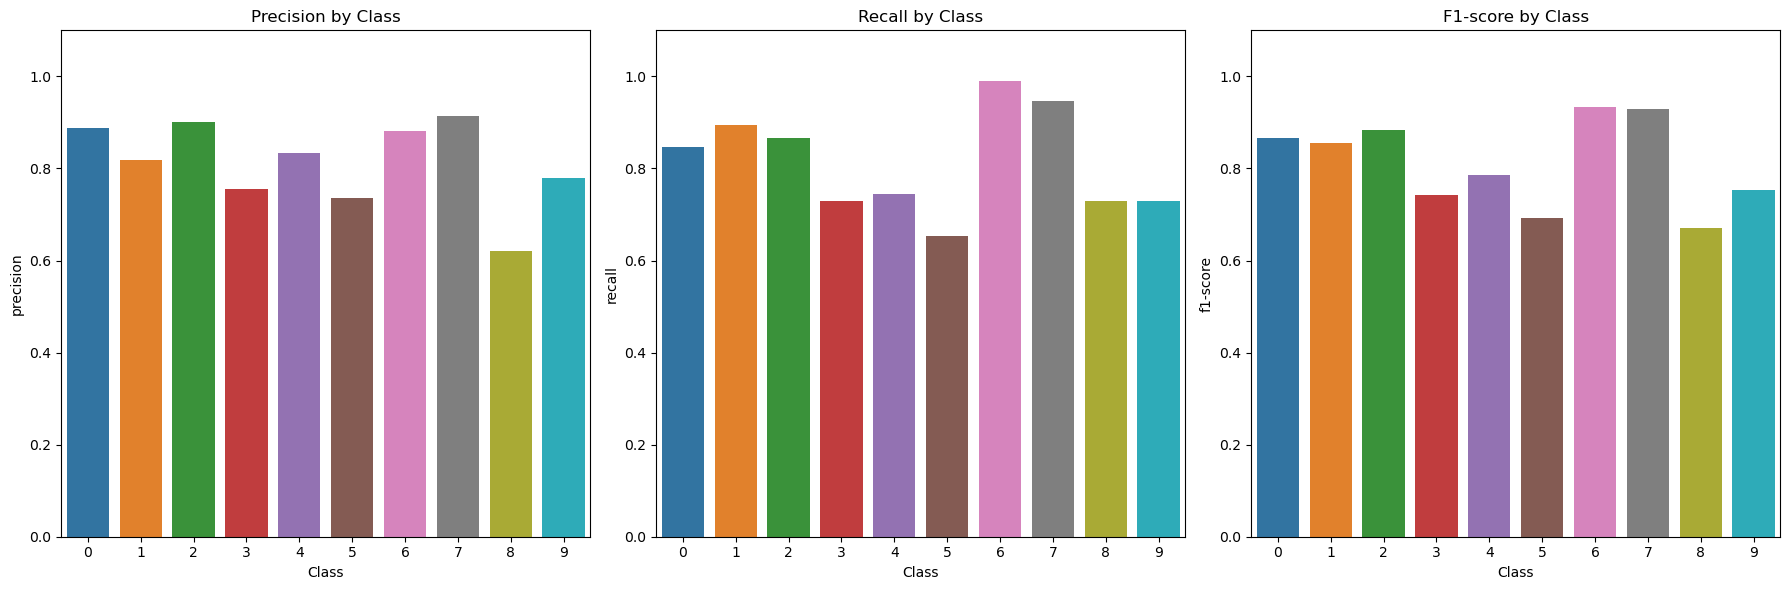

In [427]:
visualize_report(classification_report(y_test, predictions_class, output_dict=True))

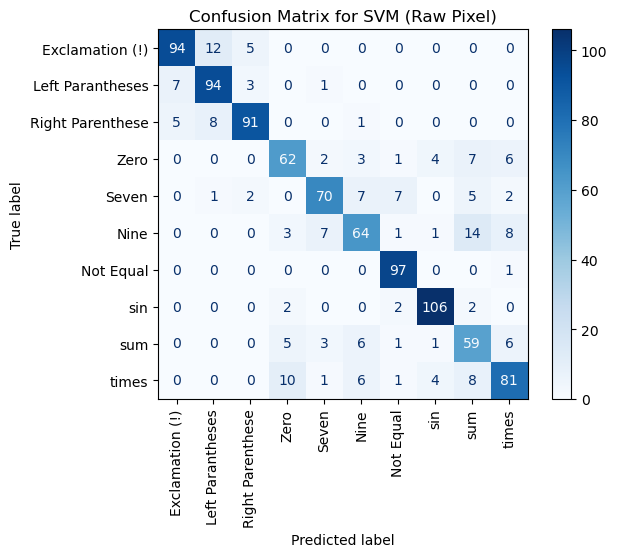

In [428]:
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(y_test, predictions_class)

# Plot the confusion matrix
plot_confusionMatrix(cm, label_map)


### Visualising Misclassification 

In [392]:
misclassified_indices = np.where(y_test!=predictions_class)[0]
print("The number of misclassified photos is ", misclassified_indices.shape)

The number of misclassified photos is  (227,)


In [429]:
visualise_misclassified_photos(images, predictions_class,y_test,X_test,label_map,2,3)

IndexError: index 6 is out of bounds for axis 0 with size 6